In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# BLACK WITHOUT FATHER

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
merged_controls = False
    
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [5]:
def load_subject(subject, data_directory, threshold1, threshold2, merged_controls=False):
    file_suffix = 'cells' + str(threshold1) if subject[0] == 'B' else 'cells' + str(threshold2)
    if merged_controls:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [6]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
#                                                                                                 data_directory=data_directory, 
#                                                                                                 threshold1=2000, 
#                                                                                                 threshold2=300, 
#                                                                                                 merged_controls=False), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_BL_woF2000.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000.npy', 
                                   allow_pickle=True).item()

In [8]:
subjects = list(dict_results_across_mice.keys())

In [9]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [10]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [10]:
df_control_cell_count.set_index('area').sum()

BL17Control    46000
BL26Control    26060
BL23Control    51372
BL44Control    11031
BL41Control    41174
BL29Control    21639
BL20Control    51968
BL32Control    24572
dtype: int64

In [11]:
df_fam_cell_count.set_index('area').sum()

BL43Fam    21042
BL24Fam    22059
BL34Fam    24774
BL21Fam    42912
BL37Fam    25208
BL27Fam    37634
BL40Fam    32040
BL30Fam    16780
BL18Fam    50231
dtype: int64

In [12]:
df_unfam_cell_count.set_index('area').sum()

BL42Unfam    24109
BL35Unfam    20408
BL22Unfam    56797
BL39Unfam    28628
BL25Unfam    36691
BL38Unfam    64619
BL31Unfam    53989
BL28Unfam    59197
BL33Unfam    20302
BL19Unfam    88763
dtype: int64

In [13]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')

In [14]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [17]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='n_cells',
                       test='mannwhitneyu',
                      alpha=0.05)

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Medial amygdalar nucleus,Cortical amygdalar area,Posterior amygdalar nucleus
1,Accessory olfactory bulb,Ventral premammillary nucleus,Bed nuclei of the stria terminalis
2,Ventral premammillary nucleus,Accessory olfactory bulb,Septohippocampal nucleus
3,Cortical amygdalar area,Posterior amygdalar nucleus,Nucleus of the brachium of the inferior collic...
4,Main olfactory bulb,Medial amygdalar nucleus,Triangular nucleus of septum
5,Periventricular hypothalamic nucleus posterior...,Periventricular hypothalamic nucleus posterior...,Piriform-amygdalar area
6,Anteromedial nucleus,Piriform-amygdalar area,Intercalated amygdalar nucleus
7,Medial preoptic nucleus,Bed nuclei of the stria terminalis,Septofimbrial nucleus
8,Perirhinal area,Medial preoptic nucleus,Medial septal complex
9,Anterodorsal preoptic nucleus,Main olfactory bulb,Vascular organ of the lamina terminalis


In [16]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial amygdalar nucleus,0.00121837
Accessory olfactory bulb,0.0019244
Ventral premammillary nucleus,0.00260341
Cortical amygdalar area,0.00407022
Main olfactory bulb,0.00407022
Periventricular hypothalamic nucleus posterior part,0.00424211
Anteromedial nucleus,0.0111081
Medial preoptic nucleus,0.0133028
Perirhinal area,0.0151914


In [17]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:40].set_index('area')

,pval_Control_vs_Unfam
area,
Cortical amygdalar area,0.000224334
Ventral premammillary nucleus,0.000261372
Accessory olfactory bulb,0.000310148
Posterior amygdalar nucleus,0.000310148
Medial amygdalar nucleus,0.000312169
Periventricular hypothalamic nucleus posterior part,0.000405096
Piriform-amygdalar area,0.000584245
Bed nuclei of the stria terminalis,0.000804534
Medial preoptic nucleus,0.00106971


In [18]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior amygdalar nucleus,0.00396802
Bed nuclei of the stria terminalis,0.00396802
Septohippocampal nucleus,0.00747283
Nucleus of the brachium of the inferior colliculus,0.00983211
Triangular nucleus of septum,0.0159526
Piriform-amygdalar area,0.0168035
Intercalated amygdalar nucleus,0.0185016
Septofimbrial nucleus,0.0248208
Medial septal complex,0.0300256


## Calculate corr matrices on number of cells

In [19]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

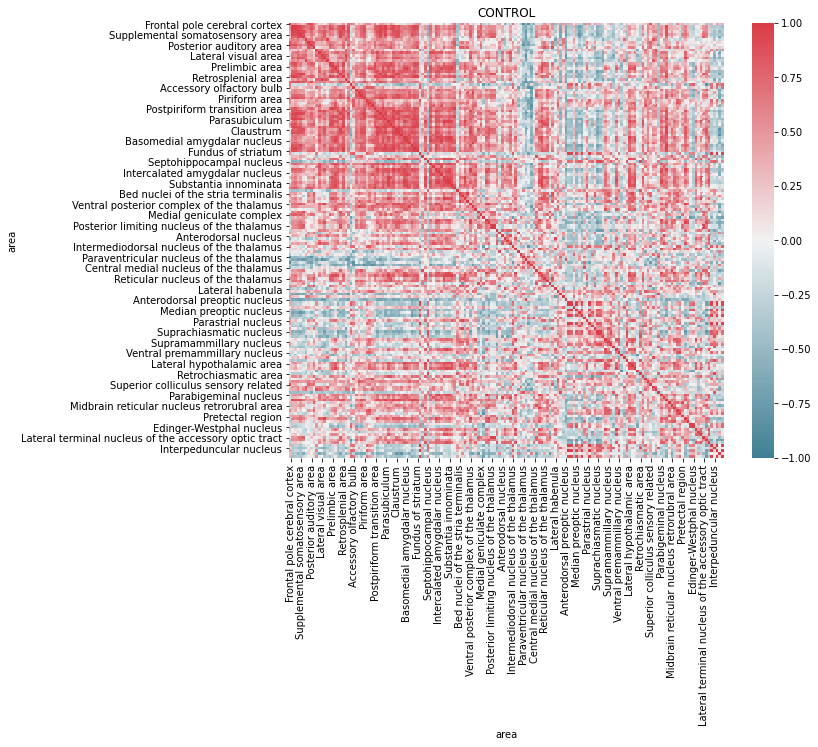

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

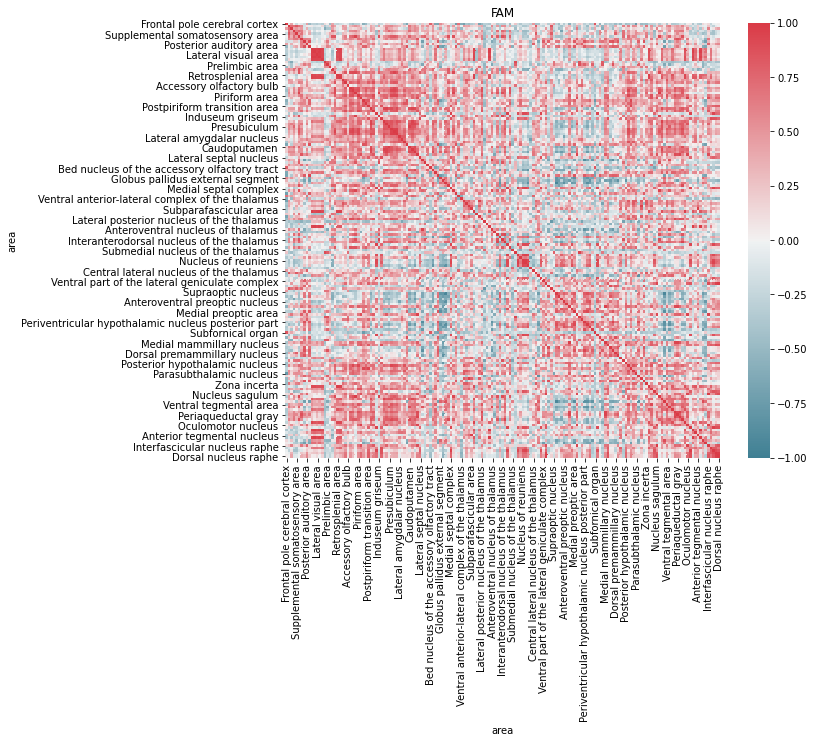

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

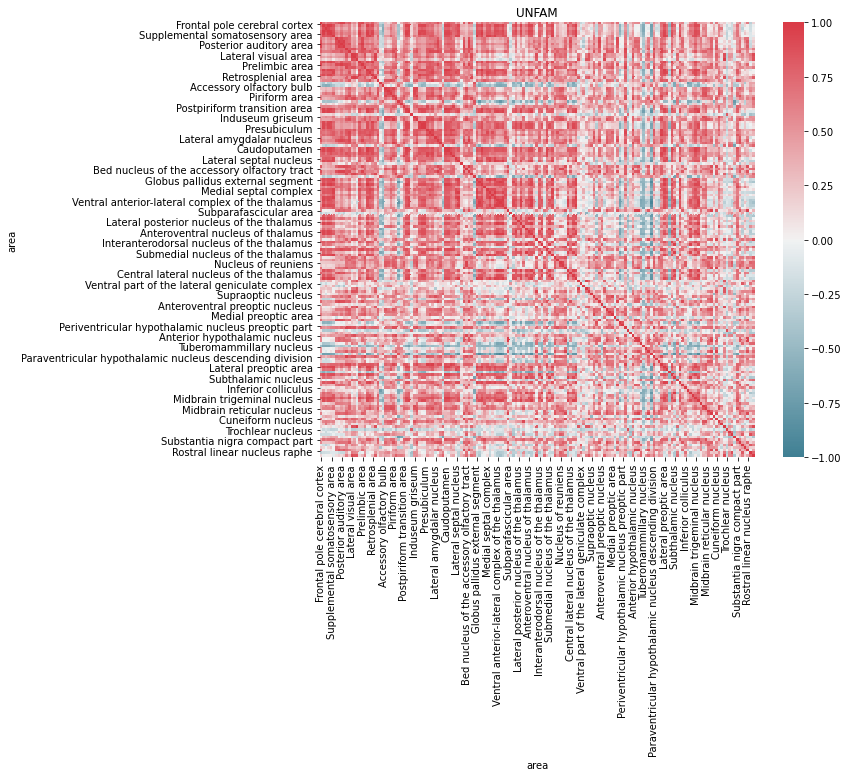

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Calculate energy across experimental groups

In [23]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [24]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy],
                                        test='mannwhitneyu')


In [25]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [26]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,0.000882057
Medial amygdalar nucleus,0.00304947
Ventral premammillary nucleus,0.00407022
Periventricular hypothalamic nucleus posterior part,0.00538671
Cortical amygdalar area,0.00706898
Main olfactory bulb,0.00919889
Piriform-amygdalar area,0.0242698
Medial preoptic nucleus,0.0242698
Supraoptic nucleus,0.0242698


In [27]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Accessory olfactory bulb,0.000312169
Cortical amygdalar area,0.000431179
Periventricular hypothalamic nucleus posterior part,0.000431179
Medial amygdalar nucleus,0.000431179
Ventral premammillary nucleus,0.000591163
Piriform-amygdalar area,0.000804534
Bed nuclei of the stria terminalis,0.000804534
Medial preoptic nucleus,0.00145754
Posterior amygdalar nucleus,0.00194034


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nuclei of the stria terminalis,0.00109982
Septohippocampal nucleus,0.00327348
Triangular nucleus of septum,0.00384564
Posterior amygdalar nucleus,0.0080055
Intercalated amygdalar nucleus,0.0123723
Nucleus of the brachium of the inferior colliculus,0.0150975
Intercollicular nucleus,0.0152431
Anterior hypothalamic area,0.0152431
Lateral strip of striatum,0.0152431


In [29]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

Text(0.5, 1.0, 'CONTROL')

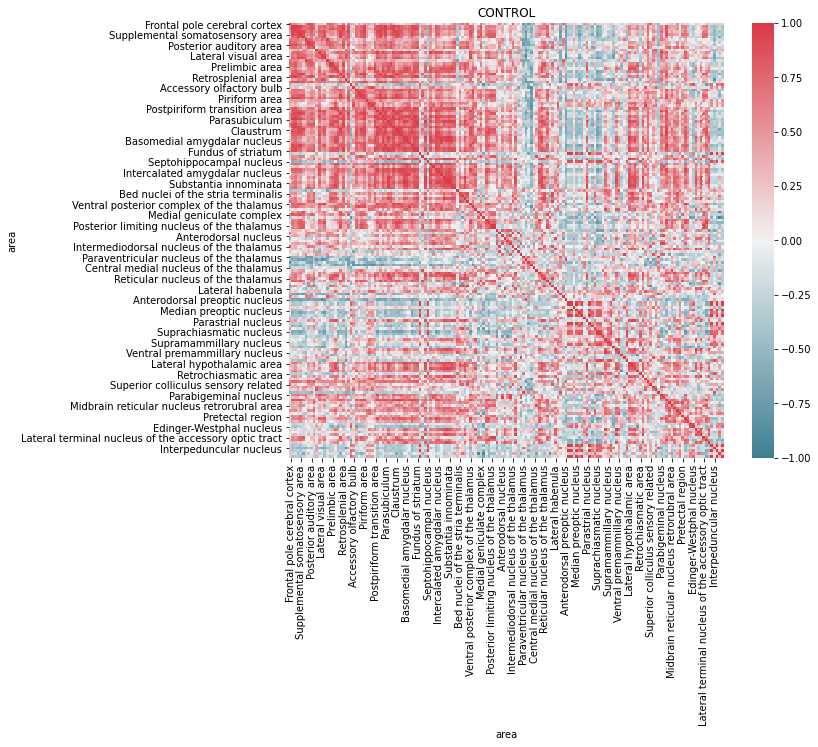

In [30]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

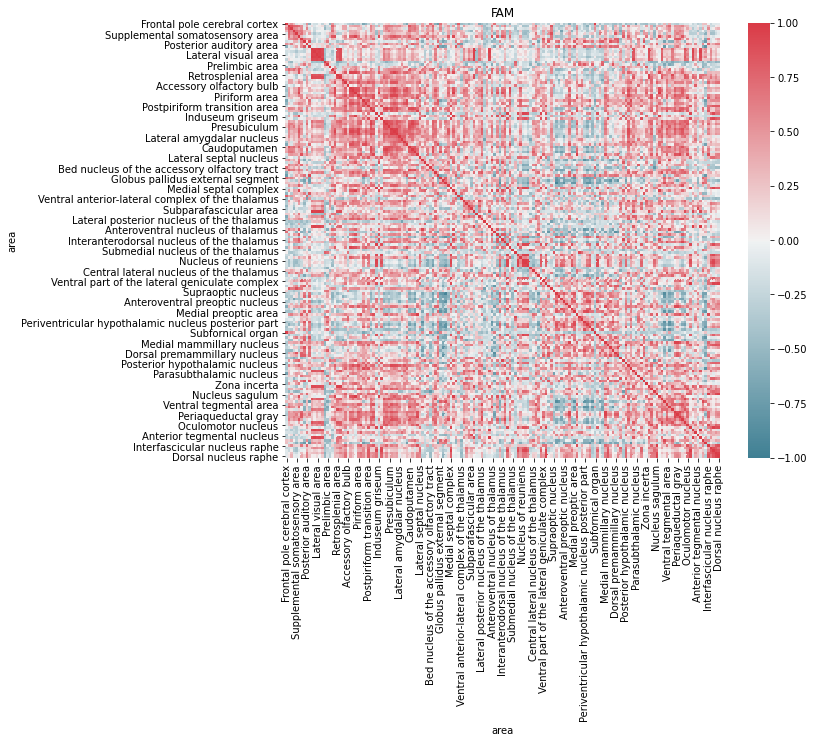

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

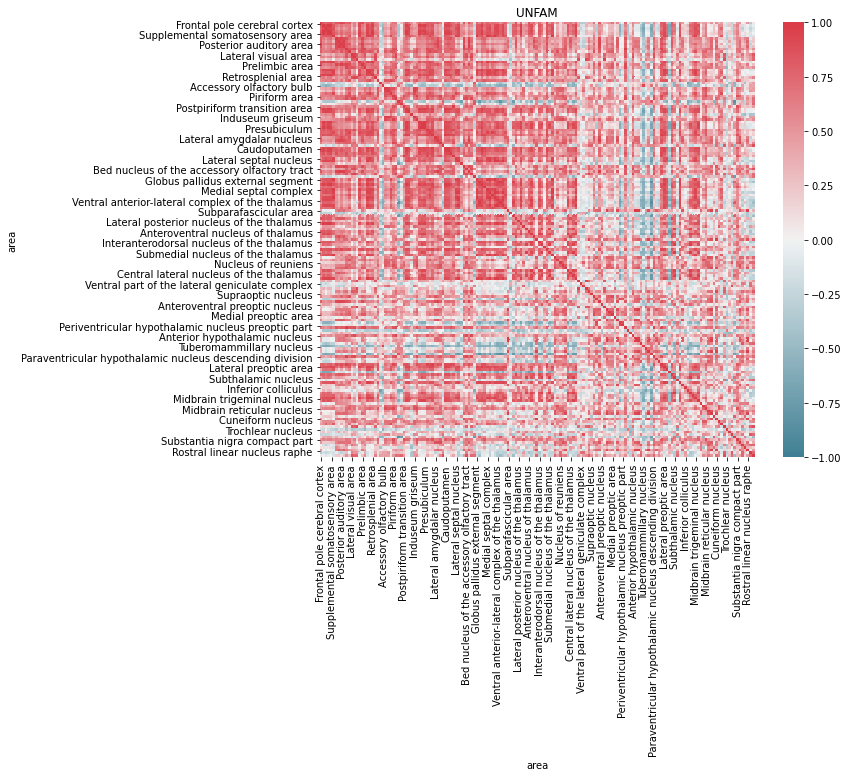

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

<AxesSubplot:xlabel='area', ylabel='number of cells'>

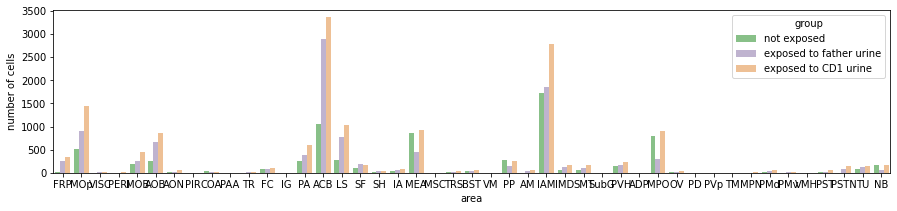

In [33]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

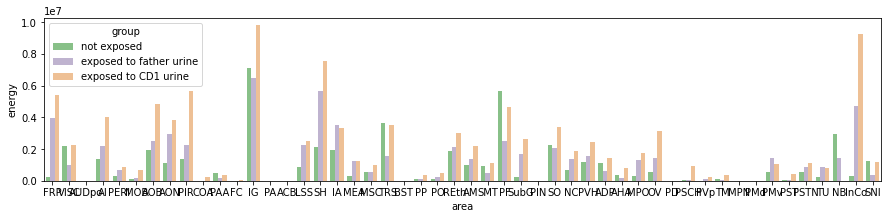

In [34]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

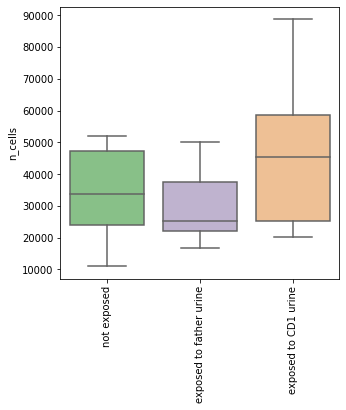

In [12]:
# stack1
subjects = subjects

control = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
fam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
unfam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
control['subject'] = [s for s in experimental_groups['Control']]
control['group'] = ['not exposed' for s in experimental_groups['Control']]
control['n_cells'] = [df_control_cell_count.set_index('area').sum()[s] for s in experimental_groups['Control']]

fam['subject'] = [s for s in experimental_groups['Fam']]
fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
fam['n_cells'] = [df_fam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Fam']]

unfam['subject'] = [s for s in experimental_groups['Unfam']]
unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
unfam['n_cells'] = [df_unfam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
sns.boxplot(
    data=with_father,
    x="group", y="n_cells", palette="Accent", ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=90)